### Baseline U-Net (5-Layer Architecture)

For comparison, a standard **5-layer U-Net** was implemented and trained on the **same dataset** with the **same random seed** to ensure fair evaluation.

- This architecture follows the traditional U-Net design with sequential downsampling and upsampling paths.
- No dense connections or long-range skip links were used.

**Result:** Served as the baseline model to evaluate the effectiveness of small-world enhancements. The **Small-World U-Net** outperformed this baseline in terms of segmentation accuracy and structural metrics.


Epoch 1: 100%|██████████| 498/498 [02:29<00:00,  3.32it/s]

Epoch Time: 149.98 sec


E1: train DICE 0.5974 | val DICE 0.5964


Epoch 2: 100%|██████████| 498/498 [02:36<00:00,  3.18it/s]

Epoch Time: 156.84 sec


E2: train DICE 0.6746 | val DICE 0.6607


Epoch 3: 100%|██████████| 498/498 [02:36<00:00,  3.17it/s]

Epoch Time: 156.88 sec


E3: train DICE 0.6922 | val DICE 0.6933


Epoch 4: 100%|██████████| 498/498 [02:36<00:00,  3.17it/s]

Epoch Time: 157.00 sec


E4: train DICE 0.7042 | val DICE 0.6890


Epoch 5: 100%|██████████| 498/498 [02:37<00:00,  3.17it/s]

Epoch Time: 157.01 sec


E5: train DICE 0.7134 | val DICE 0.6896


Epoch 6: 100%|██████████| 498/498 [02:37<00:00,  3.17it/s]

Epoch Time: 157.17 sec


E6: train DICE 0.7172 | val DICE 0.6921
Test Dice 0.6957 | IoU 0.5434


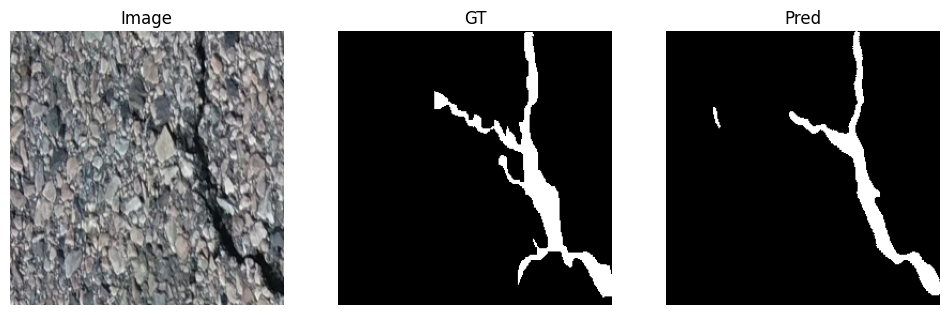

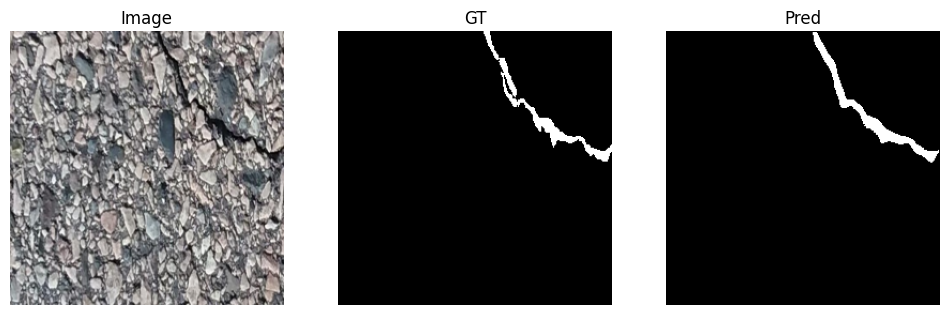

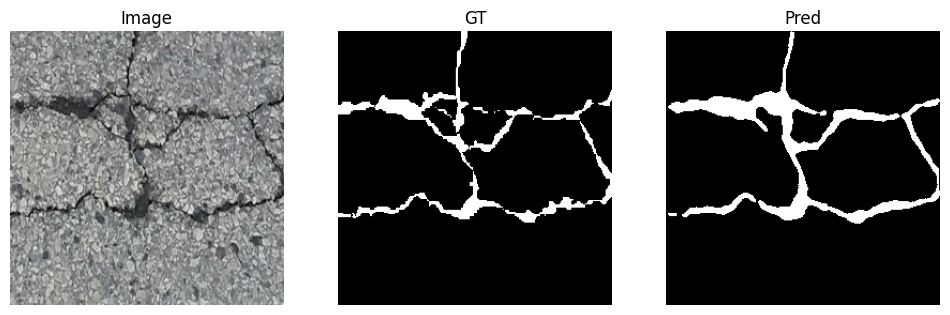

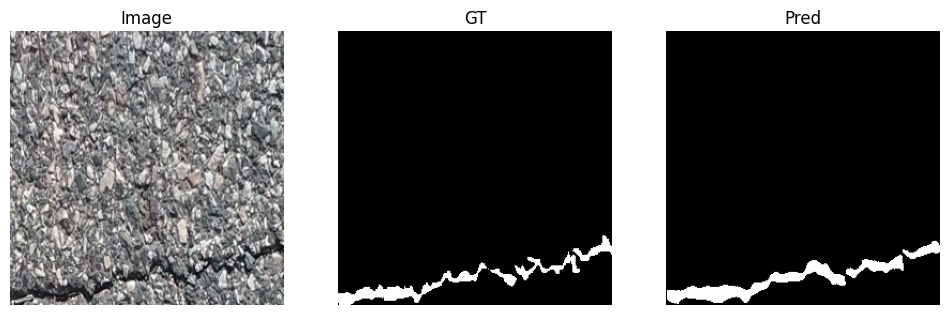

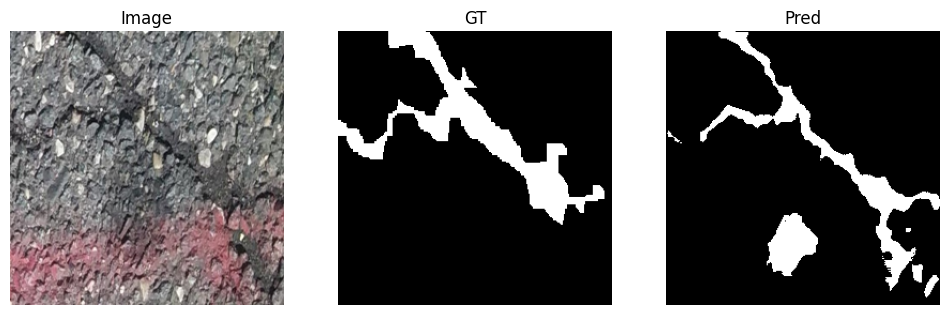

In [1]:
import os, glob, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---------------------------------------------------------------
# Set Seed for Reproducibility
# ---------------------------------------------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------------
# Dataset
# ---------------------------------------------------------------
class SatelliteDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_mask_pairs = []
        img_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))[:3000]
        for ipath in img_paths:
            fname = os.path.splitext(os.path.basename(ipath))[0]
            mpath = os.path.join(mask_dir, fname + ".jpg")
            if os.path.exists(mpath):
                self.image_mask_pairs.append((ipath, mpath))
        self.image_mask_pairs = self.image_mask_pairs[:3000]

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        ipath, mpath = self.image_mask_pairs[idx]
        img = Image.open(ipath).convert("RGB").resize((256, 256))
        mask = Image.open(mpath).convert("L").resize((256, 256), Image.NEAREST)
        img = T.ToTensor()(img)
        mask = (T.ToTensor()(mask) > 0.5).float()
        return img, mask

# ---------------------------------------------------------------
# UNet Model
# ---------------------------------------------------------------
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.pool = nn.MaxPool2d(2)

        self.enc1 = nn.Sequential(CBR(3, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.enc4 = nn.Sequential(CBR(256, 512), CBR(512, 512))

        self.bottleneck = nn.Sequential(CBR(512, 1024), CBR(1024, 1024))

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = nn.Sequential(CBR(1024, 512), CBR(512, 512))

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = nn.Sequential(CBR(512, 256), CBR(256, 256))

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(CBR(256, 128), CBR(128, 128))

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(CBR(128, 64), CBR(64, 64))

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)

# ---------------------------------------------------------------
# Metrics
# ---------------------------------------------------------------
def dice_coefficient(pred, target, eps=1e-6):
    pred, target = pred.view(-1), target.view(-1)
    inter = (pred * target).sum()
    return (2 * inter + eps) / (pred.sum() + target.sum() + eps)

def iou_score(pred, target, eps=1e-6):
    pred, target = pred.view(-1), target.view(-1)
    inter = (pred * target).sum()
    return (inter + eps) / (pred.sum() + target.sum() - inter + eps)

# ---------------------------------------------------------------
# Train / Evaluate
# ---------------------------------------------------------------
def train_model(image_dir, mask_dir):
    ds = SatelliteDataset(image_dir, mask_dir)
    assert len(ds) == 3000, f"Dataset size mismatch: {len(ds)}"
    tr, val, te = random_split(ds, [1989, 568, 3000 - 1989 - 568], generator=torch.Generator().manual_seed(42))

    tr_ld = DataLoader(tr, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
    vl_ld = DataLoader(val, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)
    te_ld = DataLoader(te, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

    net = UNet().to(device)
    opt = torch.optim.Adam(net.parameters(), lr=1e-4)
    crit = nn.BCEWithLogitsLoss()

    best, wait, patience = 0, 0, 3
    for ep in range(15):
        net.train()
        tl = td = 0
        start_time = time.time()
        for x, y in tqdm(tr_ld, desc=f"Epoch {ep+1}"):
            x, y = x.to(device), y.to(device)
            log = net(x)
            loss = crit(log, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            tl += loss.item()
            td += dice_coefficient((log > 0).float(), y).item()
        td /= len(tr_ld)
        print(f"Epoch Time: {time.time() - start_time:.2f} sec")

        net.eval()
        vd = 0
        with torch.no_grad():
            for x, y in vl_ld:
                x, y = x.to(device), y.to(device)
                p = (net(x) > 0).float()
                vd += dice_coefficient(p, y).item()
        vd /= len(vl_ld)

        print(f"E{ep+1}: train DICE {td:.4f} | val DICE {vd:.4f}")
        if vd > best:
            best, wait = vd, 0
            torch.save(net.state_dict(), "best.pth")
        else:
            wait += 1
            if wait >= patience:
                break

    net.load_state_dict(torch.load("best.pth"))
    net.eval()
    d = i = 0
    with torch.no_grad():
        for x, y in te_ld:
            x, y = x.to(device), y.to(device)
            p = (net(x) > 0).float()
            d += dice_coefficient(p, y).item()
            i += iou_score(p, y).item()
    n = len(te_ld)
    print(f"Test Dice {d / n:.4f} | IoU {i / n:.4f}")
    return net, val, te

# ---------------------------------------------------------------
# Visualisation
# ---------------------------------------------------------------
def visualize(net, dset, n=3):
    net.eval()
    for k in range(min(n, len(dset))):
        img, msk = dset[k]
        with torch.no_grad():
            p = (net(img.unsqueeze(0).to(device)).squeeze().cpu() > 0).numpy()
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(img.permute(1, 2, 0)); ax[0].set_title("Image")
        ax[1].imshow(msk.squeeze(), cmap='gray'); ax[1].set_title("GT")
        ax[2].imshow(p, cmap='gray'); ax[2].set_title("Pred")
        for a in ax:
            a.axis("off")
        plt.show()

# ---------------------------------------------------------------
# Entry-point
# ---------------------------------------------------------------
if __name__ == "__main__":
    base = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset"
    img_dir = os.path.join(base, "images")
    mask_dir = os.path.join(base, "masks")

    net, val_set, test_set = train_model(img_dir, mask_dir)
    visualize(net, val_set, 3)
    visualize(net, test_set, 2)
